# schedulers

学习速率衰减策略

In [1]:
import numpy as np

### ConstantScheduler

返回一个固定的学习速率

In [2]:
class ConstantScheduler():
    def __call__(self, step=None, cur_loss=None):
        return self.learning_rate(step=step, cur_loss=cur_loss)
    
    def __init__(self, lr=0.01, **kwargs):
        """
        Parameters
        ----------
        initial_lr : float
            The learning rate. Default is 0.01
        """
        self.lr = lr

    def learning_rate(self, **kwargs):
        """
        Returns
        -------
        lr : float
            The learning rate
        """
        return self.lr


### ExponentialScheduler

通过以下公式进行学习速率衰减:

```
            learning_rate = initial_lr * decay ** curr_stage

            curr_stage = step / stage_length          if staircase = False
            curr_stage = floor(step / stage_length)   if staircase = True
```

In [3]:
class ExponentialScheduler():
    def __init__(
        self, initial_lr=0.01, stage_length=500, staircase=False, decay=0.1, **kwargs
    ):
        """
        Parameters
        ----------
        initial_lr : float
            The learning rate at the first step. Default is 0.01.
        stage_length : int
            The length of each stage, in steps. Default is 500.
        staircase : bool
            If True, only adjusts the learning rate at the stage transitions,
            producing a step-like decay schedule. If False, adjusts the
            learning rate after each step, creating a smooth decay schedule.
            Default is False.
        decay : float
            The amount to decay the learning rate at each new stage. Default is
            0.1.
        """
        self.decay = decay
        self.staircase = staircase
        self.initial_lr = initial_lr
        self.stage_length = stage_length
        
    def __call__(self, step=None, cur_loss=None):
        return self.learning_rate(step=step, cur_loss=cur_loss)

    def learning_rate(self, step, **kwargs):
        """
        Parameters
        ----------
        step : int
            The current step number.

        Returns
        -------
        lr : float
            The learning rate for the current step.
        """
        cur_stage = step / self.stage_length
        if self.staircase:
            cur_stage = np.floor(cur_stage)
        return self.initial_lr * self.decay ** cur_stage



### NoamScheduler

先通过 `warmup_steps` 步线性的增加学习速率, 然后在减少学习速率:

```
            lr = scale_factor * ( (model_dim ** (-0.5)) * adj_step )
            adj_step = min(step_num ** (-0.5), step_num * warmup_steps ** (-1.5))
```


In [4]:
class NoamScheduler():
    def __init__(self, model_dim=512, scale_factor=1, warmup_steps=4000, **kwargs):
        """
        Parameters
        ----------
        model_dim : int
            The number of units in the layer output. Default is 512.
        scale_factor : float
            A fixed coefficient for rescaling the final learning rate. Default
            is 1.
        warmup_steps : int
            The number of steps in the warmup stage of training. Default is
            4000.
        """
        self.model_dim = model_dim
        self.scale_factor = scale_factor
        self.warmup_steps = warmup_steps
        
    def __call__(self, step=None, cur_loss=None):
        return self.learning_rate(step=step, cur_loss=cur_loss)

    def learning_rate(self, step, **kwargs):
        warmup, d_model = self.warmup_steps, self.model_dim
        new_lr = d_model ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
        return self.scale_factor * new_lr


### KingScheduler

The KingScheduler computes the probability that the slope of the OLS fit to the loss history is negative. If the probability that it is negative is less than 51% over the last `patience` steps, the scheduler exponentially decreases the current learning rate by `decay`.


In [5]:
class KingScheduler():
    def __init__(self, initial_lr=0.01, patience=1000, decay=0.99, **kwargs):
        """
        Parameters
        ----------
        initial_lr : float
            The learning rate to begin at. Default is 0.01.
        patience : int
            Amount of time to maintain the current learning rate without a
            decrease in loss before adjustment. Default is 1000.
        decay : float
            The amount to decay the learning rate at each new stage. Default is
            0.99.
        """
        self.decay = decay
        self.patience = patience
        self.initial_lr = initial_lr
        self.current_lr = initial_lr
        self.max_history = np.ceil(1.1 * (patience + 1)).astype(int)

        self.loss_history = []
        
    def __call__(self, step=None, cur_loss=None):
        return self.learning_rate(step=step, cur_loss=cur_loss)

    def _steps_without_decrease(self, robust=False, check_all=False):
        """
        Returns the maximum number of timesteps for which `P(loss is decreasing)
        < 0.51`.

        Parameters
        ----------
        robust : bool
            If `robust=True`, first filter out the largest 10% of the loss
            values to remove transient spikes in the loss due to, e.g., a few
            bad minibatches. Default is False.
        check_all : bool
            If False, returns the maximum number of timesteps for which P(loss
            is decreasing) < 0.51. If True, only checks whether the number of
            timesteps for which P(loss is decreasing) < 0.51 is equal to
            ``self.patience``. The former provides more information but is
            significantly more computationally expensive.  Default is False.

        Returns
        -------
        steps_without_decrease: int
            The maximum number of steps back in loss_history for which P(loss
            is decreasing) < 0.51.
        """
        lh = np.array(self.loss_history)

        # drop top 10% of loss values to filter out large loss spikes
        if robust:
            thresh = np.quantile(lh, 0.9)
            lh = np.array([i for i in lh if i <= thresh])

        N = len(lh)
        steps_without_decrease = 0
        if check_all:
            for i in reversed(range(N - 2)):
                if self._p_decreasing(lh, i) < 0.51:
                    steps_without_decrease = N - i
        else:
            i = max(0, N - self.patience - 1)
            if self._p_decreasing(lh, i) < 0.51:
                steps_without_decrease = N - i
        return steps_without_decrease
    
    def _gaussian_cdf(self, x, mean, var):
        """
        Compute the probability that a random draw from a 1D Gaussian with mean
        `mean` and variance `var` is less than or equal to `x`.
        """
        eps = np.finfo(float).eps
        x_scaled = (x - mean) / np.sqrt(var + eps)
        return (1 + math.erf(x_scaled / np.sqrt(2))) / 2


    def _p_decreasing(self, loss_history, i):
        """
        Compute the probability that the slope of the OLS fit to the loss
        history is negative.

        Parameters
        ----------
        loss_history : numpy array of shape (N,)
            The sequence of loss values for the previous `N` minibatches.
        i : int
            Compute P(Slope < 0) beginning at index i in `history`.

        Returns
        ------
        p_decreasing : float
            The probability that the slope of the OLS fit to loss_history is
            less than or equal to 0.
        """
        loss = loss_history[i:]
        N = len(loss)

        # perform OLS on the loss entries to calc the slope mean
        X = np.c_[np.ones(N), np.arange(i, len(loss_history))]
        intercept, s_mean = np.linalg.inv(X.T @ X) @ X.T @ loss
        loss_pred = s_mean * X[:, 1] + intercept

        # compute the variance of our loss predictions and use this to compute
        # the (unbiased) estimate of the slope variance
        loss_var = 1 / (N - 2) * np.sum((loss - loss_pred) ** 2)
        s_var = (12 * loss_var) / (N ** 3 - N)

        # compute the probability that a random sample from a Gaussian
        # parameterized by s_mean and s_var is less than or equal to 0
        p_decreasing = self._gaussian_cdf(0, s_mean, s_var)
        return p_decreasing

    def learning_rate(self, step, cur_loss):
        """
        Compute the updated learning rate for the current step and loss.

        Parameters
        ----------
        step : int
            The current step number. Unused.
        cur_loss : float
            The loss at the current step.

        Returns
        -------
        lr : float
            The learning rate for the current step.
        """
        if cur_loss is None:
            raise ValueError("cur_loss must be a float, but got {}".format(cur_loss))

        # this happens if we initialize the scheduler from a string / dict
        if not hasattr(self, "max_history"):
            self.max_history = np.ceil(1.1 * (self.patience + 1)).astype(int)
        patience, max_history = self.patience, self.max_history

        self.loss_history.append(cur_loss)
        if len(self.loss_history) < patience:
            return self.current_lr
        self.loss_history = self.loss_history[-max_history:]

        # if the loss has not decreased for `patience` timesteps, drop the
        # learning rate
        if (
            self._steps_without_decrease() > patience
            and self._steps_without_decrease(robust=True) > patience
        ):
            self.current_lr *= self.decay

        return self.current_lr


### 打印学习曲线

In [6]:
import matplotlib.pyplot as plt
import math

def king_loss_fn(x):
    if x <= 250:
        return -0.25 * x + 82.50372665317208
    elif 250 < x <= 600:
        return 20.00372665317208
    elif 600 < x <= 700:
        return -0.2 * x + 140.00372665317207
    else:
        return 0.003726653172066108


def plot_schedulers():
    fig, axes = plt.subplots(2, 2)
    schedulers = [
        (
            [ConstantScheduler(lr=0.01), "lr=1e-2"],
            [ConstantScheduler(lr=0.008), "lr=8e-3"],
            [ConstantScheduler(lr=0.006), "lr=6e-3"],
            [ConstantScheduler(lr=0.004), "lr=4e-3"],
            [ConstantScheduler(lr=0.002), "lr=2e-3"],
        ),
        (
            [
                ExponentialScheduler(
                    lr=0.01, stage_length=250, staircase=False, decay=0.4
                ),
                "lr=0.01, stage=250, stair=False, decay=0.4",
            ],
            [
                ExponentialScheduler(
                    lr=0.01, stage_length=250, staircase=True, decay=0.4
                ),
                "lr=0.01, stage=250, stair=True, decay=0.4",
            ],
            [
                ExponentialScheduler(
                    lr=0.01, stage_length=125, staircase=True, decay=0.1
                ),
                "lr=0.01, stage=125, stair=True, decay=0.1",
            ],
            [
                ExponentialScheduler(
                    lr=0.001, stage_length=250, staircase=False, decay=0.1
                ),
                "lr=0.001, stage=250, stair=False, decay=0.1",
            ],
            [
                ExponentialScheduler(
                    lr=0.001, stage_length=125, staircase=False, decay=0.8
                ),
                "lr=0.001, stage=125, stair=False, decay=0.8",
            ],
            [
                ExponentialScheduler(
                    lr=0.01, stage_length=250, staircase=False, decay=0.01
                ),
                "lr=0.01, stage=250, stair=False, decay=0.01",
            ],
        ),
        (
            [
                NoamScheduler(model_dim=512, scale_factor=1, warmup_steps=250),
                "dim=512, scale=1, warmup=250",
            ],
            [
                NoamScheduler(model_dim=256, scale_factor=1, warmup_steps=250),
                "dim=256, scale=1, warmup=250",
            ],
            [
                NoamScheduler(model_dim=512, scale_factor=1, warmup_steps=500),
                "dim=512, scale=1, warmup=500",
            ],
            [
                NoamScheduler(model_dim=256, scale_factor=1, warmup_steps=500),
                "dim=512, scale=1, warmup=500",
            ],
            [
                NoamScheduler(model_dim=512, scale_factor=2, warmup_steps=500),
                "dim=512, scale=2, warmup=500",
            ],
            [
                NoamScheduler(model_dim=512, scale_factor=0.5, warmup_steps=500),
                "dim=512, scale=0.5, warmup=500",
            ],
        ),
        (
            [
                KingScheduler(initial_lr=0.009, patience=150, decay=0.995),
                "lr=0.009, patience=150, decay=0.9999",
            ],
            [
                KingScheduler(initial_lr=0.008, patience=100, decay=0.995),
                "lr=0.008, patience=100, decay=0.995",
            ],
            [
                KingScheduler(initial_lr=0.007, patience=50, decay=0.995),
                "lr=0.007, patience=50, decay=0.995",
            ],
            [
                KingScheduler(initial_lr=0.005, patience=25, decay=0.9),
                "lr=0.005, patience=25, decay=0.99",
            ],
        ),
    ]

    for ax, schs, title in zip(
        axes.flatten(), schedulers, ["Constant", "Exponential", "Noam", "King"]
    ):
        X = np.arange(1, 1000)
        loss = np.array([king_loss_fn(x) for x in X])

        # scale loss to fit on same axis as lr
        scale = 0.01 / loss[0]
        loss *= scale

        if title == "King":
            ax.plot(X, loss, ls=":", label="Loss")

        for sc, lg in schs:
            Y = np.array([sc(x, ll) for x, ll in zip(X, loss)])
            ax.plot(X, Y, label=lg, alpha=0.6)

        ax.legend(fontsize=5)
        ax.set_xlabel("Steps")
        ax.set_ylabel("Learning rate")
        ax.set_title("{} scheduler".format(title))

    plt.tight_layout()
    plt.show()


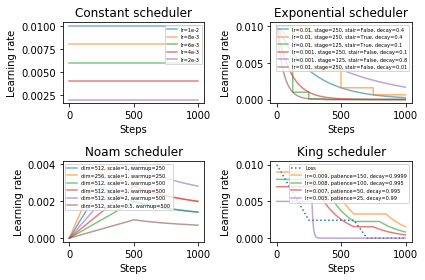

In [7]:
plot_schedulers()